In [1]:
import pandas as pd

df_docs = pd.read_csv('cranfield_docs.csv')
df_topics = pd.read_csv('cranfield_topics.csv')
df_relevance = pd.read_csv('cranfield_qrels.csv')
display(df_docs.shape, df_topics.shape, df_relevance.shape)

(1398, 2)

(225, 2)

(1837, 3)

# 1- Trying different custom retreivers

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer


class IRSystem:
	def __init__(self, vectorizer=None, preprocess=None):
		self.vectorizer = vectorizer if vectorizer else TfidfVectorizer(stop_words='english', lowercase=True)
		self.preprocess = preprocess if preprocess else lambda x: x

		self.doc_vectors = None
		self.doc_ids = []
		self.docs = []

	def index(self, df_docs):
		print("Indexation des documents...")
		self.docs = df_docs['text'].apply(self.preprocess).tolist()
		self.doc_ids = df_docs['docno'].tolist()
		self.doc_vectors = self.vectorizer.fit_transform(self.docs)
		
	def retrieve_ss1(self, df_queries, top_k=10):
		results = []
		for _, row in df_queries.iterrows():
			qid, query = row["qid"], self.preprocess(row["query"])
			query_vec = self.vectorizer.transform([query])
			scores = cosine_similarity(query_vec, self.doc_vectors).flatten()
			top_indices = scores.argsort()[::-1][:top_k]
			for rank, idx in enumerate(top_indices):
				results.append({
					"qid": qid,
					"docno": self.doc_ids[idx],
					"score": scores[idx],
					"rank": rank + 1
				})

		return pd.DataFrame(results)
	
	def retrieve_ss2(self, df_queries, qrels_df, x2=3):
		results = []
		qrel_dict = qrels_df.set_index(["qid", "docno"])["label"].to_dict()

		for _, row in df_queries.iterrows():
			qid, query = row["qid"], self.preprocess(row["query"])
			query_vec = self.vectorizer.transform([query])
			scores = cosine_similarity(query_vec, self.doc_vectors).flatten()

			ranked_indices = scores.argsort()[::-1]
			non_rel_count = 0

			for rank, idx in enumerate(ranked_indices):
				docno = self.doc_ids[idx]
				rel = qrel_dict.get((qid, docno), 0)
				results.append({
					"qid": qid,
					"docno": docno,
					"score": scores[idx],
					"rank": rank + 1
				})

				if rel == 0:
					non_rel_count += 1
				if non_rel_count >= x2:
					break

		return pd.DataFrame(results)

	def retrieve_ss3(self, df_queries, qrels_df, x3=3):
		results = []
		qrel_dict = qrels_df.set_index(["qid", "docno"])["label"].to_dict()

		for _, row in df_queries.iterrows():
			qid, query = row["qid"], self.preprocess(row["query"])
			query_vec = self.vectorizer.transform([query])
			scores = cosine_similarity(query_vec, self.doc_vectors).flatten()

			ranked_indices = scores.argsort()[::-1]
			non_rel_streak = 0

			for rank, idx in enumerate(ranked_indices):
				docno = self.doc_ids[idx]
				rel = qrel_dict.get((qid, docno), 0)
				results.append({
					"qid": qid,
					"docno": docno,
					"score": scores[idx],
					"rank": rank + 1
				})

				if rel == 0:
					non_rel_streak += 1
					if non_rel_streak >= x3:
						break
				else:
					non_rel_streak = 0 

		return pd.DataFrame(results)


In [ ]:
#BM25
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

class BM25Vectorizer:
    def __init__(self, k1=1.2, b=0.75, tokenizer=None, stop_words='english'):
        self.k1 = k1
        self.b = b
        self.cv = CountVectorizer(tokenizer=tokenizer, stop_words=stop_words)
        self.avdl = None
        self.doc_len = None
        self.idf = None
        self.fitted = False

    def fit_transform(self, corpus):
        tf = self.cv.fit_transform(corpus)
        n_docs, n_terms = tf.shape
        self.doc_len = np.asarray(tf.sum(axis=1)).flatten()
        self.avdl = np.mean(self.doc_len)

        df = np.diff(tf.indptr) 
        df = np.asarray((tf > 0).sum(axis=0)).flatten()

        self.idf = np.log(1 + (n_docs - df + 0.5) / (df + 0.5))

        self.fitted = True
        return self._bm25_weight(tf)

    def transform(self, queries):
        if not self.fitted:
            raise ValueError("You must call fit_transform() first")

        tf = self.cv.transform(queries)
        return self._bm25_weight(tf)

    def _bm25_weight(self, tf):
        rows, cols = tf.nonzero()
        data = []

        for i, j in zip(rows, cols):
            tf_ij = tf[i, j]
            dl = self.doc_len[i] if self.doc_len is not None else 1
            denom = tf_ij + self.k1 * (1 - self.b + self.b * dl / self.avdl)
            score = self.idf[j] * tf_ij * (self.k1 + 1) / denom
            data.append(score)

        bm25_matrix = csr_matrix((data, (rows, cols)), shape=tf.shape)
        return bm25_matrix


In [28]:
#dense vectorizer
from sentence_transformers import SentenceTransformer

class DenseVectorizer:
    def __init__(self, model_name="all-MiniLM-L6-v2"):
        self.model = SentenceTransformer(model_name)

    def fit_transform(self, docs):
        return self.model.encode(docs, convert_to_tensor=False)

    def transform(self, queries):
        return self.model.encode(queries, convert_to_tensor=False)


In [29]:
#LSA 
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

lsi_vectorizer = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    TruncatedSVD(n_components=50, random_state=42)  # 100 dimensions, ajustable
)


In [30]:
ir_tfidf = IRSystem(vectorizer=TfidfVectorizer())
ir_bm25 = IRSystem(vectorizer=BM25Vectorizer(b=0.75, k1=1.2))
ir_counter = IRSystem(vectorizer=CountVectorizer())
ir_sentence = IRSystem(vectorizer=DenseVectorizer())
ir_lsi = IRSystem(vectorizer=lsi_vectorizer)

ir_tfidf.index(df_docs)
ir_bm25.index(df_docs)
ir_counter.index(df_docs)
ir_sentence.index(df_docs)
ir_lsi.index(df_docs)

Indexation des documents...
Indexation des documents...
Indexation des documents...
Indexation des documents...
Indexation des documents...


5it [01:43, 20.77s/it]


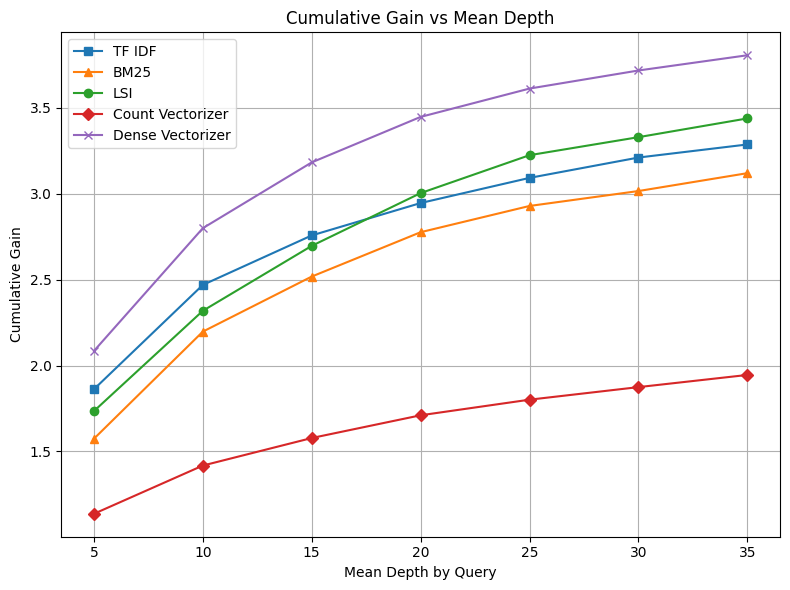

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cg_vs_mean_depth_multi(results_func_list, df_queries, df_qrels, topk_range=[5, 10, 15, 20], labels=None, title="Cumulative Gain vs Mean Depth", markers=None):
	if labels is None:
		labels = [f"Run {i+1}" for i in range(len(results_func_list))]
	qrel_dict = df_qrels.set_index(["qid", "docno"])["label"].to_dict()
	
	def compute_cg(results_df):
		dcg = 0
		for i, row in results_df.iterrows():
			rel = qrel_dict.get((row["qid"], row["docno"]), 0)
			dcg += rel / np.log2(row["rank"] + 1)
		return dcg

	plt.figure(figsize=(8, 6))

	for i, (retrieve_func, label) in tqdm(enumerate(zip(results_func_list, labels))):
		depths = []
		gains = []

		for k in topk_range:
			results_df = retrieve_func(k)
			grouped = results_df.groupby("qid")
			mean_depth = grouped["rank"].max().mean()
			mean_cg = compute_cg(results_df) / len(grouped)

			depths.append(mean_depth)
			gains.append(mean_cg)

		marker = None if markers is None else markers[i]
		plt.plot(depths, gains, marker=marker or 'o', label=label)

	plt.xlabel("Mean Depth by Query")
	plt.ylabel("Cumulative Gain")
	plt.title(title)
	plt.grid(True)
	plt.legend()
	plt.tight_layout()
	plt.show()


plot_cg_vs_mean_depth_multi(
	results_func_list=[
		lambda k: ir_tfidf.retrieve_ss1(df_topics, top_k=k),
		lambda k: ir_bm25.retrieve_ss1(df_topics, top_k=k),
		lambda k: ir_lsi.retrieve_ss1(df_topics, top_k=k),
		lambda k: ir_counter.retrieve_ss1(df_topics, top_k=k),
		lambda k: ir_sentence.retrieve_ss1(df_topics, top_k=k)
	],
	df_queries=df_topics,
	df_qrels=df_relevance,
	topk_range=range(5,40 , 5),
	labels=["TF IDF","BM25", "LSI", "Count Vectorizer", "Dense Vectorizer"],
	markers=["s", "^", "o", "D", "x"]
)


# 2- Trying different SS (on dense vectorisez)

,Stratégie,Paramètre optimal (xi),Mean depth/query,nDCG
0,SS1,7,7.0000,0.5844
1,SS2,4,6.0356,0.5955
2,SS3,3,5.7289,0.5976


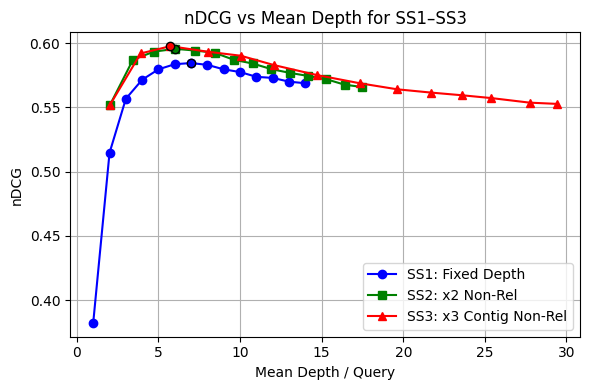

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_ss1_to_3(ir, df_docs, df_queries, df_qrels, topk_range=[5,10,15,20], x2_range=[1,2,3,4], x3_range=[1,2,3,4]):

	qrel_dict = df_qrels.set_index(["qid", "docno"])["label"].to_dict()

	def compute_depth_and_cg(results_df, xi):
		results_df["label"] = results_df.apply(lambda row: qrel_dict.get((row["qid"], row["docno"]), 0), axis=1)
		grouped = results_df.groupby("qid")
		mean_depth = grouped["rank"].max().mean()
		dcg_total = 0
		idcg_total = 0
		for qid, group in grouped:
			rels = group.sort_values("rank")["label"].values
			dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(rels))
			ideal_rels = sorted(rels, reverse=True)
			idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_rels))
			dcg_total += dcg
			idcg_total += idcg if idcg > 0 else 1 
		ndcg = dcg_total / idcg_total
		return mean_depth, ndcg, xi

	ss1_points = []
	for k in topk_range:
		results = ir.retrieve_ss1(df_queries, top_k=k)
		ss1_points.append(compute_depth_and_cg(results, k))
	ss2_points = []
	for x2 in x2_range:
		results = ir.retrieve_ss2(df_queries, df_qrels, x2=x2)
		ss2_points.append(compute_depth_and_cg(results, x2))
	ss3_points = []
	for x3 in x3_range:
		results = ir.retrieve_ss3(df_queries, df_qrels, x3=x3)
		ss3_points.append(compute_depth_and_cg(results, x3))

	best_ss1 = max(ss1_points, key=lambda x: x[1])
	best_ss2 = max(ss2_points, key=lambda x: x[1])
	best_ss3 = max(ss3_points, key=lambda x: x[1])
	df_summary = pd.DataFrame({
		"Stratégie": ["SS1", "SS2", "SS3"],
		"Paramètre optimal (xi)": [best_ss1[2], best_ss2[2], best_ss3[2]],
		"Mean depth/query": [round(best_ss1[0], 4), round(best_ss2[0], 4), round(best_ss3[0], 4)],
		"nDCG": [round(best_ss1[1], 4), round(best_ss2[1], 4), round(best_ss3[1], 4)]
	})
	display(df_summary)

	x1, y1, _ = zip(*ss1_points)
	x2, y2, _ = zip(*ss2_points)
	x3, y3, _ = zip(*ss3_points)
	best_ss1 = max(ss1_points, key=lambda x: x[1])
	best_ss2 = max(ss2_points, key=lambda x: x[1])
	best_ss3 = max(ss3_points, key=lambda x: x[1])

	plt.figure(figsize=(6, 4))
	plt.plot(x1, y1, marker='o', color='blue', label="SS1: Fixed Depth")
	plt.plot(x2, y2, marker='s', color='green', label="SS2: x2 Non-Rel")
	plt.plot(x3, y3, marker='^', color='red', label="SS3: x3 Contig Non-Rel")
	plt.scatter(best_ss1[0], best_ss1[1], color='blue', edgecolors='black', zorder=5)
	plt.scatter(best_ss2[0], best_ss2[1], color='green', edgecolors='black', zorder=5)
	plt.scatter(best_ss3[0], best_ss3[1], color='red', edgecolors='black', zorder=5)

	plt.xlabel("Mean Depth / Query")
	plt.ylabel("nDCG")
	plt.title("nDCG vs Mean Depth for SS1–SS3")
	plt.grid(True)
	plt.legend()
	plt.tight_layout()
	plt.show()



plot_ss1_to_3(
	ir_lsi,
	df_docs,
	df_topics,
	df_relevance,
	topk_range= range(1, 15, 1),
	x2_range=range(1, 15, 1),
	x3_range=range(1, 15, 1)
)
